In [1]:
import os, math
from collections import OrderedDict
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, recall_score
import pennylane as qml
from torch.serialization import add_safe_globals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CLASSES       = ["A","B","C","D","E"]        # must match training order
IMG_SIZE      = (112, 112)
E             = 128                          # ResNet head emb dim
D_EMBED       = 8                            # reduced embedding fed to VQC
N_QUBITS      = 4
VQC_LAYERS    = 2
HIDDEN_LAYER  = 64
T_FRAMES      = 6                            # rolling window size used at inference
STRIDE        = 3                            # VQC stride used in training
DEVICE_TYPE   = "lightning.qubit"            # or "lightning.gpu" if installed
INTERFACE     = "torch"
DIFF_METHOD   = "adjoint"                    # fine for inference
IMG_CKPT      = "best_img.pth"
SEQ_BUNDLE    = "final_bundle_seq.pth"
EVAL_DIR      = "./val"                     # change this to your local eval folder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

In [3]:
class ResNetEmbed(nn.Module):
    def __init__(self, emb_dim=E, num_classes=len(CLASSES), pretrained=False, freeze_stem=True):
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = models.resnet18(weights=weights)
        in_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        if freeze_stem:
            for name, p in self.backbone.named_parameters():
                if name.startswith(("conv1", "bn1", "layer1")):
                    p.requires_grad = False

        self.proj = nn.Sequential(nn.Linear(in_dim, emb_dim), nn.ReLU(inplace=True))
        self.head_cls = nn.Linear(emb_dim, num_classes)  # unused at inference
        self.reduce_to_d = nn.Linear(emb_dim, D_EMBED)   # must match D_EMBED

    def forward(self, x, return_embed_only=False):
        feat512 = self.backbone(x)
        emb = self.proj(feat512)
        if return_embed_only:
            return emb
        logits = self.head_cls(emb)
        return emb, logits

In [4]:
class CNNtoDE(nn.Module):
    def __init__(self, cnn):
        super().__init__()
        self.cnn = cnn
    def forward(self, x):
        emb = self.cnn(x, return_embed_only=True)
        de  = self.cnn.reduce_to_d(emb)
        return de

In [5]:
class VQC_Layer(nn.Module):
    def __init__(self, d_embed=D_EMBED, n_qubits=N_QUBITS, layers=VQC_LAYERS,
                 device_type=DEVICE_TYPE, interface=INTERFACE, diff_method=DIFF_METHOD):
        super().__init__()
        self.n_qubits = n_qubits

        # classical parts
        self.pre = nn.Sequential(
            nn.LayerNorm(d_embed),
            nn.Linear(d_embed, d_embed, bias=True),
            nn.GELU()
        )
        self.to_qubits = nn.Linear(d_embed, n_qubits)
        self.angle_scale = nn.Parameter(torch.tensor(1.0))

        self.post = nn.Sequential(
            nn.LayerNorm(n_qubits),
            nn.Linear(n_qubits, n_qubits, bias=True),
            nn.GELU()
        )

        nn.init.xavier_uniform_(self.to_qubits.weight)
        if self.to_qubits.bias is not None:
            nn.init.constant_(self.to_qubits.bias, 0)
        for layer in self.pre:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight); nn.init.constant_(layer.bias, 0)
        for layer in self.post:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight); nn.init.constant_(layer.bias, 0)

        # quantum params
        import math as _math
        self.theta = nn.Parameter(torch.zeros(layers, n_qubits, 3))
        with torch.no_grad():
            self.theta.uniform_(-_math.pi, _math.pi)

        # make a device and bind qnode
        self._dev = qml.device(device_type, wires=n_qubits)

        @qml.qnode(self._dev, interface=interface, diff_method=diff_method)
        def _qnode(x_qubits, theta):
            qml.AngleEmbedding(x_qubits, wires=range(n_qubits), rotation="Y")
            qml.StronglyEntanglingLayers(theta, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        self._qnode = _qnode  # bound method-like closure

    def forward(self, x):
        # x: (B,D) or (B,T,D)
        is_seq = x.dim() == 3
        if is_seq:
            B, T, D = x.shape
            x = x.view(B*T, D)

        z  = self.pre(x)
        xq = self.to_qubits(z)
        scale = 0.5 + F.softplus(self.angle_scale)
        xq = torch.tanh(xq * scale) * (math.pi/2)

        # Pennylane QNodes return torch tensors with shape (n_qubits,)
        out = self._qnode(xq, self.theta)          # -> (n_qubits,) * (B or B*T) internally
        out = torch.stack(out, dim=-1)             # (B or B*T, n_qubits)
        out = out.to(xq.device, dtype=xq.dtype)
        out = self.post(out)

        if is_seq:
            return out.view(B, T, self.n_qubits)
        return out

In [6]:
# QLSTM with 4 separate QNodes (f, i, u, o)
def _make_qnode(n_qubits, device_type=DEVICE_TYPE, interface=INTERFACE, diff_method=DIFF_METHOD):
    dev = qml.device(device_type, wires=n_qubits)
    @qml.qnode(dev, interface=interface, diff_method=diff_method)
    def _q(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]
    return _q

class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits=N_QUBITS, n_layers=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_qubits = n_qubits

        self.fc = nn.Sequential(
            nn.Linear(input_size, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, n_qubits, bias=True)
        )
        self.input_gain = nn.Parameter(torch.ones(n_qubits) * (math.pi/2))

        # quantum weights
        self.f_weight = nn.Parameter(torch.empty(n_layers, n_qubits, 3))
        self.i_weight = nn.Parameter(torch.empty(n_layers, n_qubits, 3))
        self.u_weight = nn.Parameter(torch.empty(n_layers, n_qubits, 3))
        self.o_weight = nn.Parameter(torch.empty(n_layers, n_qubits, 3))
        with torch.no_grad():
            for p in (self.f_weight, self.i_weight, self.u_weight, self.o_weight):
                p.uniform_(-math.pi, math.pi)

        self.q2hidden = nn.Sequential(
            nn.Linear(n_qubits, hidden_size, bias=True),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size, bias=True)
        )
        self.forget_bias = nn.Parameter(torch.ones(hidden_size))
        self.output = nn.Sequential(nn.Linear(hidden_size, 1, bias=True))

        # four QNodes
        self.qforget = _make_qnode(n_qubits)
        self.qinput  = _make_qnode(n_qubits)
        self.qupdate = _make_qnode(n_qubits)
        self.qoutput = _make_qnode(n_qubits)

    def forward(self, x):  # x: (B,T,n_qubits)
        B, T, _ = x.shape
        device = x.device
        h_t = torch.zeros(B, self.hidden_size, device=device)
        c_t = torch.zeros(B, self.hidden_size, device=device)

        for t in range(T):
            x_t = self.fc(x[:, t, :]) * self.input_gain

            f = torch.stack(self.qforget(x_t, self.f_weight), dim=-1).to(device, x_t.dtype)
            i = torch.stack(self.qinput( x_t, self.i_weight), dim=-1).to(device, x_t.dtype)
            u = torch.stack(self.qupdate(x_t, self.u_weight), dim=-1).to(device, x_t.dtype)
            o = torch.stack(self.qoutput(x_t, self.o_weight), dim=-1).to(device, x_t.dtype)

            f = torch.sigmoid(self.q2hidden(f) + self.forget_bias)
            i = torch.sigmoid(self.q2hidden(i))
            o = torch.sigmoid(self.q2hidden(o))
            u = torch.tanh(   self.q2hidden(u))

            c_t = f * c_t + i * u
            h_t = o * torch.tanh(c_t)

        y = self.output(h_t)
        return y, h_t

In [7]:
class TimeWiseVQC(nn.Module):
    def __init__(self, vqc_layer: VQC_Layer, stride=STRIDE):
        super().__init__()
        self.vqc = vqc_layer
        self.stride = stride
    def forward(self, de_seq):  # (B,T,D_EMBED)
        B, T, D = de_seq.shape
        idx = torch.arange(0, T, self.stride, device=de_seq.device)
        x_sub = de_seq[:, idx, :]
        q_coarse = self.vqc(x_sub)  # (B, T/stride, n_qubits)
        q_full   = torch.repeat_interleave(q_coarse, repeats=self.stride, dim=1)
        q_full   = q_full[:, :T, :]
        return q_full

In [8]:
class Hybrid_Quantum_ALS_Sequence(nn.Module):
    def __init__(self, vqc_seq: TimeWiseVQC, qlstm_cell: QLSTMCell,
                 num_classes=len(CLASSES), hidden=HIDDEN_LAYER):
        super().__init__()
        self.vqc_seq = vqc_seq
        self.qlstm   = qlstm_cell
        self.head    = nn.Linear(hidden, num_classes)
    def forward(self, de_seq):  # (B,T,D_EMBED)
        q_seq = self.vqc_seq(de_seq)
        _, h_t = self.qlstm(q_seq)
        logits = self.head(h_t)
        return logits

In [9]:
def build_feature_model():
    cnn = ResNetEmbed(emb_dim=E, num_classes=len(CLASSES), pretrained=False, freeze_stem=True)
    cnn.reduce_to_d = nn.Linear(E, D_EMBED)
    feat = CNNtoDE(cnn)
    return feat

In [10]:
def build_sequence_model():
    vqc = VQC_Layer(d_embed=D_EMBED, n_qubits=N_QUBITS, layers=VQC_LAYERS)
    vqc_seq = TimeWiseVQC(vqc, stride=STRIDE)
    qlstm = QLSTMCell(input_size=N_QUBITS, hidden_size=HIDDEN_LAYER, n_qubits=N_QUBITS, n_layers=2)
    seq = Hybrid_Quantum_ALS_Sequence(vqc_seq, qlstm, num_classes=len(CLASSES), hidden=HIDDEN_LAYER)
    return seq

In [11]:
@torch.no_grad()
def _load_feature_weights(feature_model, img_ckpt_path):
    if not os.path.exists(img_ckpt_path):
        print(f"[WARN] {img_ckpt_path} not found; feature model random init.")
        return
    try:
        pkg = torch.load(img_ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        pkg = torch.load(img_ckpt_path, map_location=device)

    # Accept either direct state_dict or nested "model_state"
    state = pkg.get("model_state", pkg.get("state_dict", pkg))
    remap = OrderedDict()
    for k, v in state.items():
        # training saved 'features.cnn.*' — strip that to 'cnn.*'
        if k.startswith("features.cnn."):
            remap[k.replace("features.cnn.", "cnn.")] = v
        elif k.startswith("cnn."):
            remap[k] = v
        # ignore classifier head if present
    missing, unexpected = feature_model.load_state_dict(remap, strict=False)
    if missing:
        print("[INFO] Missing feature weights:", missing[:8], "…")
    if unexpected:
        print("[INFO] Unexpected feature weights:", unexpected[:8], "…")


In [12]:
@torch.no_grad()
def _load_seq_weights(seq_model, seq_bundle_path):
    if not os.path.exists(seq_bundle_path):
        print(f"[WARN] {seq_bundle_path} not found; sequence model random init.")
        return
    
    add_safe_globals([Hybrid_Quantum_ALS_Sequence, TimeWiseVQC, VQC_Layer, QLSTMCell])
    try:
        pkg = torch.load(seq_bundle_path, map_location=device, weights_only=False)
    except TypeError:
        pkg = torch.load(seq_bundle_path, map_location=device)

    ckpt = pkg.get("checkpoint", {})
    state = ckpt.get("model_state", None)
    if state is None:
        if all(isinstance(k, str) and torch.is_tensor(v) for k, v in pkg.items()):
            state = pkg
        else:
            raise RuntimeError("No model_state found in final bundle; re-export with state_dict next time.")
    missing, unexpected = seq_model.load_state_dict(state, strict=False)
    if missing:
        print("[INFO] Missing seq weights:", missing[:8], "…")
    if unexpected:
        print("[INFO] Unexpected seq weights:", unexpected[:8], "…")

In [13]:
@torch.no_grad()
def load_models(img_ckpt=IMG_CKPT, seq_bundle=SEQ_BUNDLE):
    feat = build_feature_model()
    seq  = build_sequence_model()
    _load_feature_weights(feat, img_ckpt)
    _load_seq_weights(seq, seq_bundle)
    feat.eval().to(device); seq.eval().to(device)
    return feat, seq

In [14]:
class EvalStillAsSeq(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, T_frames=T_FRAMES, img_size=IMG_SIZE):
        super().__init__()
        self.root = Path(root_dir)
        self.classes = [c.upper() for c in classes]
        self.cls2idx = {c:i for i,c in enumerate(self.classes)}
        self.T = T_frames
        H, W = img_size
        self.tr = T.Compose([
            T.Resize((H, W)),
            T.ToTensor(),
            T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ])
        self.samples = []
        for c in self.classes:
            for p in sorted((self.root / c).glob("*.jpg")) + sorted((self.root / c).glob("*.png")) + sorted((self.root / c).glob("*.jpeg")):
                self.samples.append((str(p), self.cls2idx[c]))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        frames = [self.tr(img) for _ in range(self.T)]
        x = torch.stack(frames, dim=0)  # (T,3,H,W)
        return x, y, p

In [15]:
@torch.no_grad()
def predict_batch(feature, seq_model, batch_x):
    # batch_x: (B,T,3,H,W) -> DE per frame -> sequence logits
    B, T, C, H, W = batch_x.shape
    x_flat = batch_x.view(B*T, C, H, W).to(device, non_blocking=True)
    de_flat = feature(x_flat)                       # (B*T, D_EMBED)
    de_seq = de_flat.view(B, T, D_EMBED)           # (B, T, D_EMBED)
    logits = seq_model(de_seq)                     # (B, num_classes)
    return logits

In [16]:
@torch.no_grad()
def evaluate_dir(eval_dir=EVAL_DIR, batch_size=32):
    if not os.path.isdir(eval_dir):
        raise FileNotFoundError(f"Eval dir not found: {eval_dir}")
    ds = EvalStillAsSeq(eval_dir, CLASSES, T_frames=T_FRAMES, img_size=IMG_SIZE)
    if len(ds) == 0:
        raise RuntimeError(f"No images found under {eval_dir}/<class>/*.jpg|png")
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    feature, seq = load_models(IMG_CKPT, SEQ_BUNDLE)

    all_preds, all_labels, all_paths = [], [], []
    for xb, yb, pb in loader:
        logits = predict_batch(feature, seq, xb)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy().tolist())
        all_paths.extend(pb)

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Metrics
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    bal_acc  = balanced_accuracy_score(y_true, y_pred)
    per_cls_recall = recall_score(y_true, y_pred, average=None, labels=list(range(len(CLASSES))), zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))

    print("\n=== Results ===")
    print("Classes:", CLASSES)
    print(f"Macro-F1:            {macro_f1:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print("Per-class recall:")
    for i, r in enumerate(per_cls_recall):
        print(f"  {CLASSES[i]}: {r:.4f}")
    print("\nConfusion matrix (rows=true, cols=pred):")
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    return cm, macro_f1, bal_acc, per_cls_recall

In [17]:
feature, seq = load_models(IMG_CKPT, SEQ_BUNDLE)
cm, macro_f1, bal_acc, per_cls_recall = evaluate_dir(EVAL_DIR, batch_size=128)

/home/afoek/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Results ===
Classes: ['A', 'B', 'C', 'D', 'E']
Macro-F1:            0.9780
Balanced Accuracy:   0.9780
Per-class recall:
  A: 0.9367
  B: 0.9933
  C: 1.0000
  D: 0.9933
  E: 0.9667

Confusion matrix (rows=true, cols=pred):
[[281   0   0   0  19]
 [  1 298   0   0   1]
 [  0   0 300   0   0]
 [  0   2   0 298   0]
 [  9   1   0   0 290]]

Classification report:
              precision    recall  f1-score   support

           A     0.9656    0.9367    0.9509       300
           B     0.9900    0.9933    0.9917       300
           C     1.0000    1.0000    1.0000       300
           D     1.0000    0.9933    0.9967       300
           E     0.9355    0.9667    0.9508       300

    accuracy                         0.9780      1500
   macro avg     0.9782    0.9780    0.9780      1500
weighted avg     0.9782    0.9780    0.9780      1500



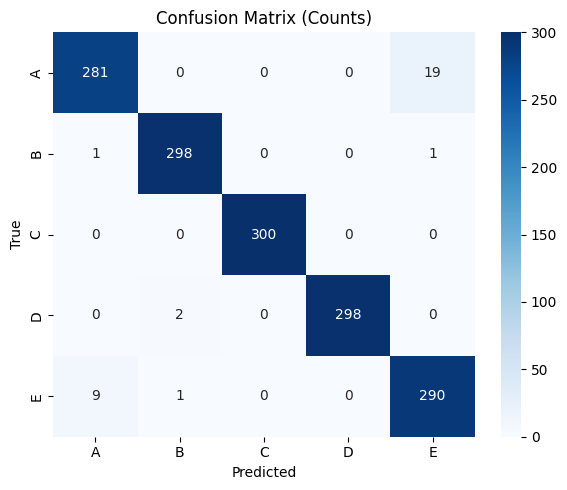

In [18]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=CLASSES, yticklabels=CLASSES,
    cbar=True, ax=ax
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Counts)")
fig.tight_layout()
fig.savefig("fig_cm_counts.png", dpi=300)
plt.show()

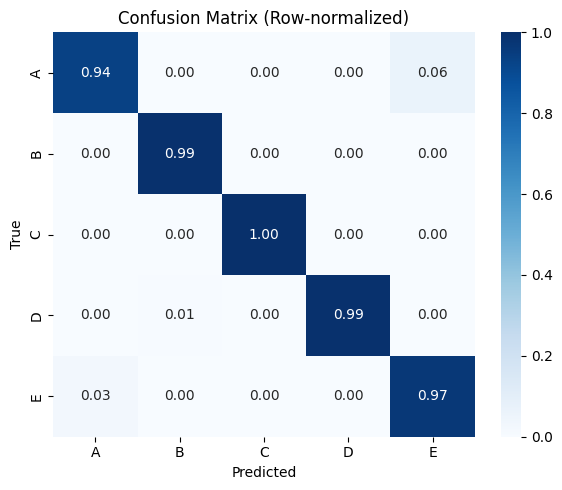

In [19]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True, fmt=".2f", cmap="Blues",
    xticklabels=CLASSES, yticklabels=CLASSES,
    vmin=0, vmax=1, cbar=True, ax=ax
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Row-normalized)")
fig.tight_layout()
fig.savefig("fig_cm_normalized.png", dpi=300)
plt.show()

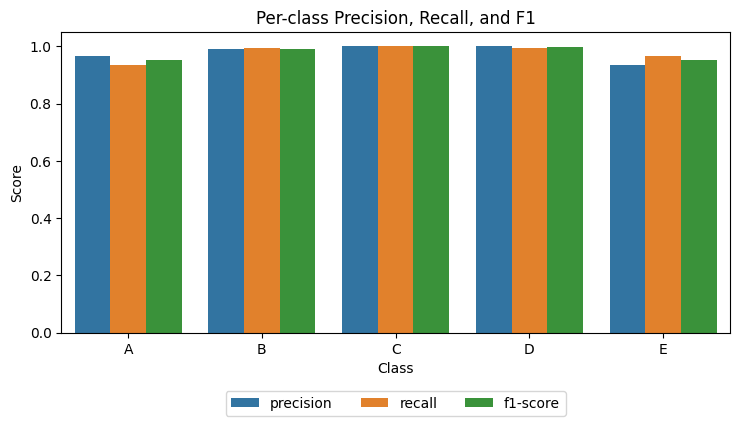

In [20]:
cm = np.asarray(cm)  # ensure ndarray
TP        = np.diag(cm).astype(float)
support   = cm.sum(axis=1).astype(float)            # true counts per class
pred_counts = cm.sum(axis=0).astype(float)          # predicted counts per class

precision = TP / np.clip(pred_counts, 1, None)
recall    = TP / np.clip(support, 1, None)
f1        = 2 * precision * recall / np.clip(precision + recall, 1e-12, None)

per_class_df = pd.DataFrame({
    "class":     CLASSES,
    "support":   support.astype(int),
    "precision": precision,
    "recall":    recall,
    "f1-score":  f1,
}).round(4)

melted = per_class_df.melt(
    id_vars=["class", "support"],
    value_vars=["precision", "recall", "f1-score"],
    var_name="metric", value_name="score"
)

fig, ax = plt.subplots(figsize=(7.5, 4.5))
sns.barplot(
    data=melted, x="class", y="score", hue="metric",
    ax=ax
)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_xlabel("Class")
ax.set_title("Per-class Precision, Recall, and F1")
ax.legend(title=None, ncol=3, loc="lower center", bbox_to_anchor=(0.5, -0.3))
fig.tight_layout()
fig.savefig("fig_per_class_metrics.png", dpi=300)
plt.show()

In [21]:
vqc = seq.vqc_seq.vqc                  # your trained VQC_Layer
qlstm = seq.qlstm                      # your trained QLSTMCell
nq = qlstm.n_qubits
xq = torch.linspace(-math.pi/2, math.pi/2, steps=nq)

In [22]:
def stop_condition(op):
    name = getattr(op, "name", "")
    if name in {"RX", "RY", "RZ", "CNOT"}:
        return True
    return isinstance(op, (qml.RX, qml.RY, qml.RZ, qml.CNOT))

In [23]:
def force_decompose(qfunc, max_depth=12):
    return qml.transforms.decompose(qfunc, stopping_condition=stop_condition, max_expansion=max_depth)

In [24]:
def draw_to_rgb_array(qfunc, *args, decimals=2, title=None):
    fig, ax = qml.draw_mpl(
        qfunc, show_all_wires=True, decimals=decimals, expansion_strategy="device"
    )(*args)
    if title:
        ax.set_title(title)
    fig.tight_layout()
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    img = np.asarray(buf, dtype=np.uint8)[..., :3]
    plt.close(fig)
    return img

In [25]:
def imsave_grid(images, titles, grid=(2,2), suptitle=None, outfile="out.png", figsize=(16,9), dpi=300):
    r, c = grid
    fig, axes = plt.subplots(r, c, figsize=figsize, dpi=dpi)
    axes = axes.ravel()
    for ax, img, t in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(t)
        ax.axis("off")
    for ax in axes[len(images):]:
        ax.axis("off")
    if suptitle:
        fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight", dpi=dpi)
    plt.show()

In [26]:
wF = qlstm.f_weight.detach().cpu().numpy().astype(np.float64)
wI = qlstm.i_weight.detach().cpu().numpy().astype(np.float64)
wU = qlstm.u_weight.detach().cpu().numpy().astype(np.float64)
wO = qlstm.o_weight.detach().cpu().numpy().astype(np.float64)
Wv = vqc.theta.detach().cpu().numpy().astype(np.float64)

In [27]:
def make_gate_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev, interface=None)  # drawing only
    def qnode(x, weights):
        qml.AngleEmbedding(x, wires=range(n_qubits))  # defaults to rotation="Y"
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return qnode

qforget_circuit = make_gate_qnode(qlstm.n_qubits)
qinput_circuit  = make_gate_qnode(qlstm.n_qubits)
qupdate_circuit = make_gate_qnode(qlstm.n_qubits)
qoutput_circuit = make_gate_qnode(qlstm.n_qubits)

In [28]:
vqc_dev = qml.device("default.qubit", wires=vqc.n_qubits)
@qml.qnode(vqc_dev, interface=None)
def vqc_circuit(x, weights):
    qml.AngleEmbedding(x, wires=range(vqc.n_qubits))  # rotation="Y" like your layer
    qml.StronglyEntanglingLayers(weights, wires=range(vqc.n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(vqc.n_qubits)]

qforget_dec = force_decompose(qforget_circuit, max_depth=12)
qinput_dec  = force_decompose(qinput_circuit,  max_depth=12)
qupdate_dec = force_decompose(qupdate_circuit, max_depth=12)
qoutput_dec = force_decompose(qoutput_circuit, max_depth=12)
vqc_dec     = force_decompose(vqc_circuit,     max_depth=12)

In [33]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [34]:
imgs = []
titles = []
for qn, W, title in [
    (qforget_dec, wF, "Forget gate (decomposed)"),
    (qinput_dec,  wI, "Input gate (decomposed)"),
    (qupdate_dec, wU, "Update gate (decomposed)"),
    (qoutput_dec, wO, "Output gate (decomposed)"),
]:
    img = draw_to_rgb_array(qn, xq, W, decimals=2, title=None)
    imgs.append(img); titles.append(title)

imsave_grid(imgs, titles, grid=(2,2),
            suptitle="QLSTM circuits – decomposed to RX/RY/RZ+CNOT",
            outfile="qlstm_circuits_grid_decomposed.png", figsize=(20,12), dpi=600)

/tmp/ipykernel_21995/3845420314.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_21995/3845420314.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_21995/3845420314.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_21995/3845420314.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


/tmp/ipykernel_21995/3845420314.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


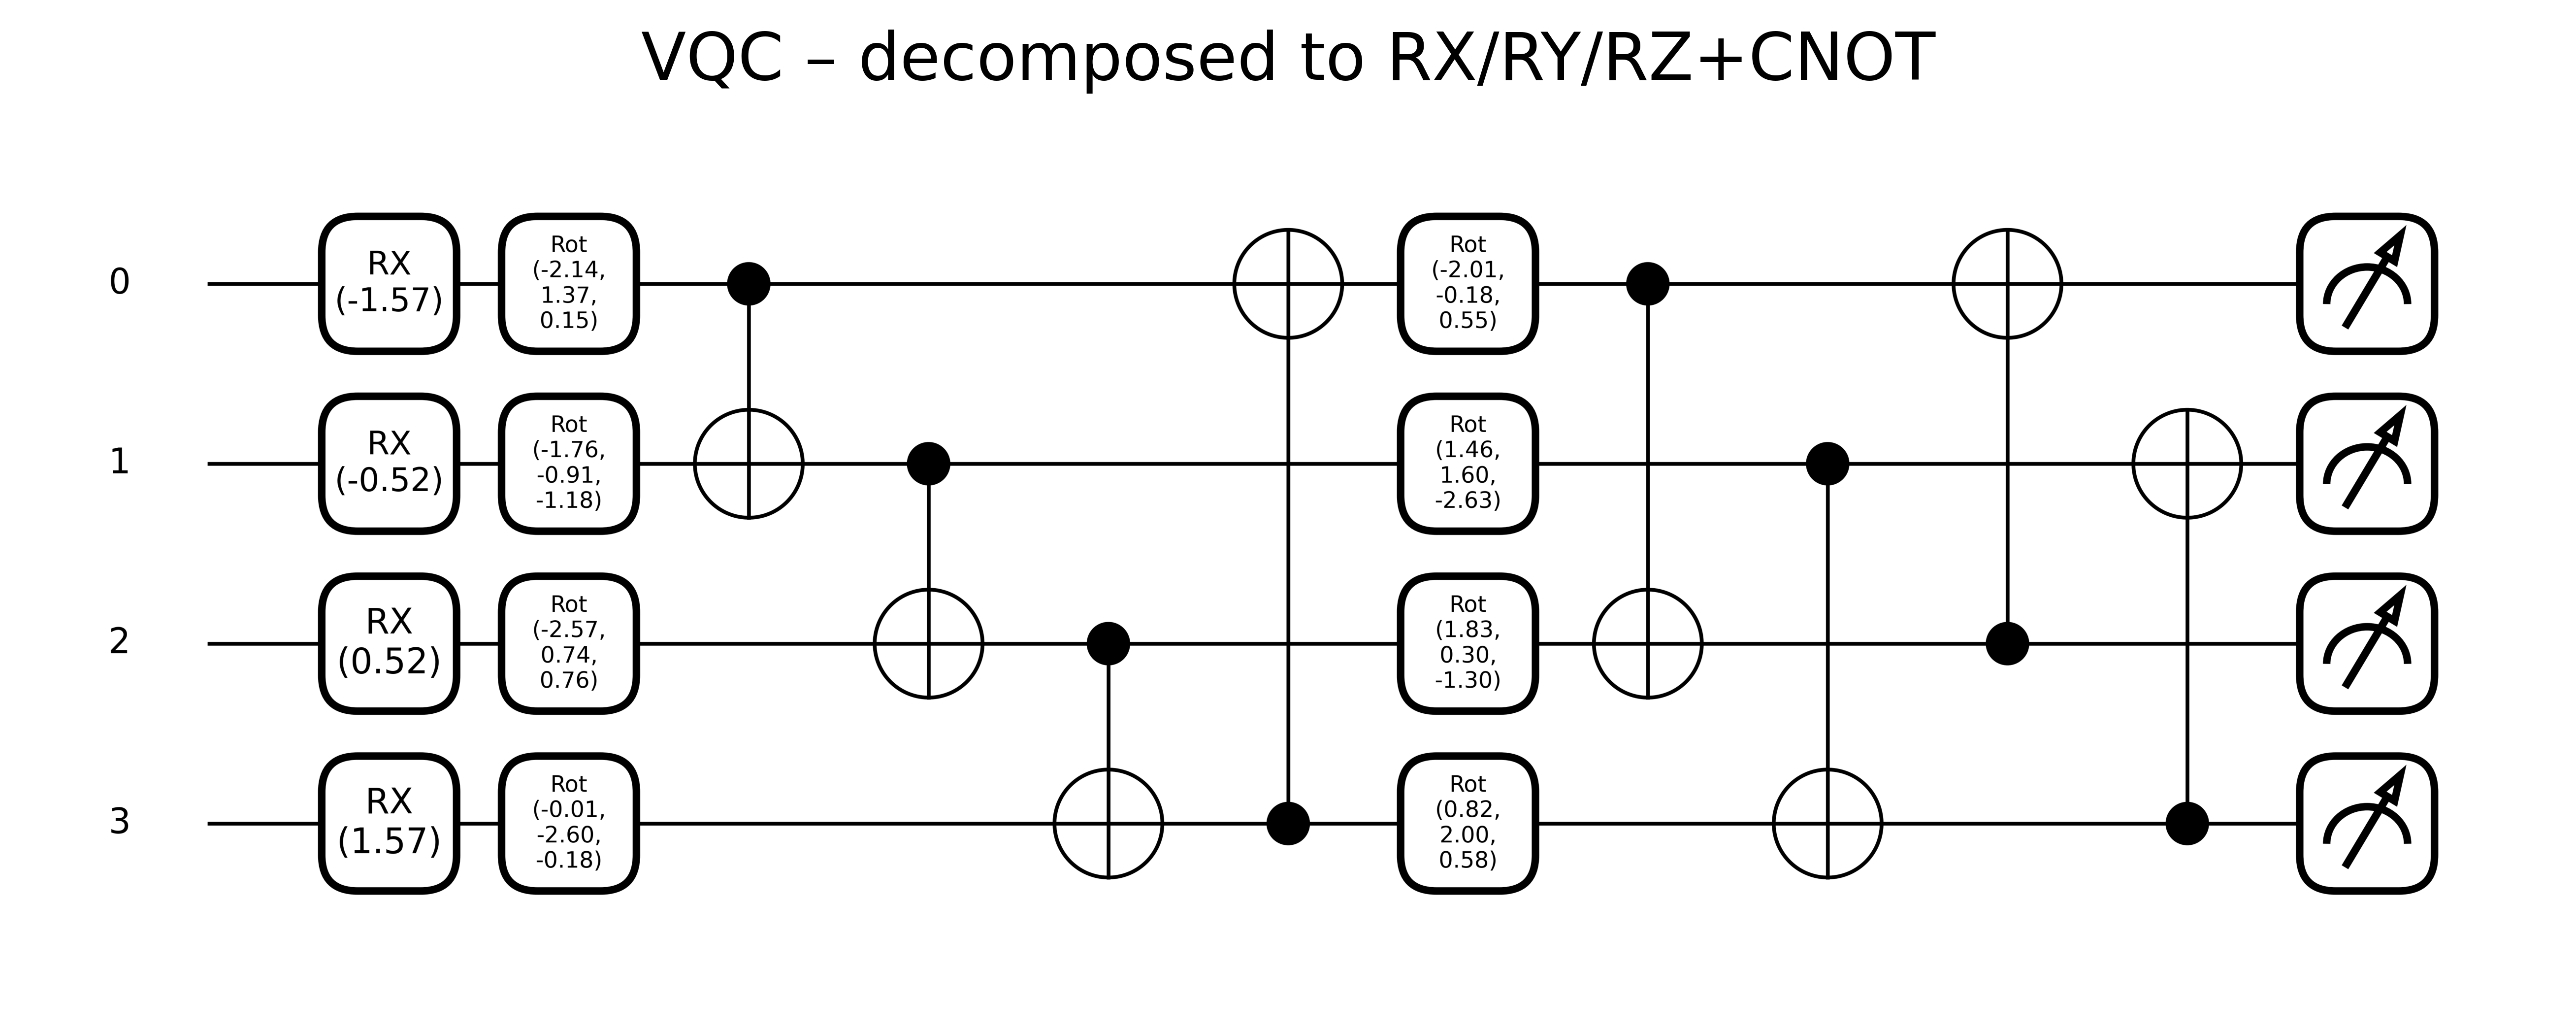

In [35]:
vqc_img = draw_to_rgb_array(vqc_dec, xq, Wv, decimals=2, title=None)
plt.figure(figsize=(9,9), dpi=600)
plt.imshow(vqc_img); plt.axis("off")
plt.title("VQC – decomposed to RX/RY/RZ+CNOT")
plt.tight_layout()
plt.savefig("vqc_decomposed.png", bbox_inches="tight", dpi=600)
plt.show()